In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import netCDF4 as nc
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import weibull_min
from sklearn import preprocessing
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, scale
import warnings

warnings.simplefilter('ignore')

In [2]:
#Utils
def outliers_info(df):
    outliers_data = {
        'feature': [],
        'lower_limit': [],
        'upper_limit': [],
        'below_count': [],
        'above_count': [],
        'percent_above': [],
        'percent_below': [],
    }

    for column in df:
        if df[column].dtype != "object" or df[column].dtype != "bool":
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR

            above = (df[column] > upper).sum()
            below = (df[column] <= lower).sum()

            outliers_data['feature'].append(column)
            outliers_data['lower_limit'].append(np.round(lower, 2))
            outliers_data['upper_limit'].append(np.round(upper, 2))
            outliers_data['below_count'].append(np.round(below, 2))
            outliers_data['above_count'].append(np.round(above, 2))
            outliers_data['percent_above'].append(np.round(above / len(df), 2))
            outliers_data['percent_below'].append(np.round(below / len(df), 2))

    return outliers_data


def mask_outliers(df, replace):
    # Calculate Q1 and Q2 quantile
    q = df.agg('quantile', q=[.25, .75])

    # Calculate IQR = Q2 - Q1
    iqr = q.loc[.75] - q.loc[.25]

    # Calculate lower and upper limits to decide outliers
    lower = q.loc[.25] - 1.5 * iqr
    upper = q.loc[.75] + 1.5 * iqr

    # Replace the values that does not lies between [lower, upper]
    return df.where(df.ge(lower) & df.le(upper), replace)


def fit_weibull(df, column):
    data = df[column]
    shape, loc, scale = weibull_min.fit(data, loc=0)
    
    plt.figure(figsize = (15, 4))

    # Plot the histogram of the original data
    plt.subplot(1, 2, 1)
    plt.hist(data, density=True, bins=10, alpha=0.5, label='Data')

    # Generate x-values for the PDF plot
    x = np.linspace(0, np.max(data), 100)

    # Plot the PDF of the fitted Weibull distribution
    plt.plot(x, weibull_min.pdf(x, shape, loc, scale), 'r-', label='Fitted Weibull PDF')

    # Add labels and legend
    plt.xlabel('X')
    plt.ylabel('Probability Density')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column])
    
    # Show the plot
    plt.show()
    
    return pd.Series((shape, loc, scale), index=['k: shape', 'loc', 'a: scale'])


def weibull(data):
    for col in data:
        if data[col].dtype == 'float64':
            print(col)
            print(fit_weibull(data, col))

In [3]:
# Params
file_path = 'Data/Risoe/risoe_m_all.nc'
signals= ['ws77', 'wd77', 'ws125', 'wd125']
base_date = datetime(1995, 11, 20, 14, 25, 0) # includes correction for time zone
csv_path = 'Data/Risoe/meso_Risoe.csv'

In [4]:
meso = pd.read_csv(csv_path, sep=',')
meso

,TIMESTAMP,HGT,RHO060,RHO080,RHO100,RHO120,RHO140,RHO160,RHO180,RHO200,...,TKE_PBL220,RH060,RH080,RH100,RH120,RH140,RH160,RH180,RH200,RH220
0,2001-06-10 15:00:00,7.770000,1.234208,1.232239,1.230234,1.228201,1.226122,1.224005,1.221824,1.219543,...,0.10,69.34,69.59,69.78,69.91,69.88,69.70,69.36,68.77,68.25
1,2001-06-10 16:00:00,7.770000,1.230668,1.228701,1.226703,1.224679,1.222648,1.220613,1.218572,1.216524,...,0.20,63.85,64.41,64.98,65.55,66.13,66.71,67.30,67.89,68.49
2,2001-06-10 17:00:00,7.770000,1.230054,1.228041,1.226011,1.223966,1.221926,1.219891,1.217852,1.215805,...,0.10,63.23,63.78,64.35,64.95,65.57,66.21,66.84,67.49,68.13
3,2001-06-10 18:00:00,7.770000,1.229966,1.227930,1.225889,1.223844,1.221794,1.219739,1.217687,1.215639,...,0.10,64.66,65.03,65.48,66.01,66.55,67.12,67.70,68.31,68.93
4,2001-06-10 19:00:00,7.770000,1.233801,1.231368,1.228940,1.226516,1.224150,1.221833,1.219564,1.217368,...,0.10,65.39,64.26,63.19,62.19,61.58,61.29,61.45,62.27,63.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204283,2020-09-24 08:00:00,7.772932,1.197993,1.195880,1.193761,1.191636,1.189495,1.187339,1.185160,1.182938,...,0.98,91.64,92.40,93.14,93.86,94.53,95.15,95.70,96.12,96.53
204284,2020-09-24 09:00:00,7.772932,1.197598,1.195588,1.193582,1.191580,1.189581,1.187586,1.185593,1.183605,...,1.06,87.29,87.83,88.41,89.02,89.65,90.31,90.99,91.71,92.43
204285,2020-09-24 10:00:00,7.772932,1.196508,1.194758,1.192947,1.191076,1.189182,1.187264,1.185338,1.183396,...,1.15,65.51,66.35,67.15,67.90,68.65,69.38,70.11,70.83,71.56
204286,2020-09-24 11:00:00,7.772932,1.197121,1.195391,1.193597,1.191739,1.189858,1.187952,1.186039,1.184110,...,1.28,66.19,67.17,68.10,68.98,69.84,70.68,71.53,72.37,73.21


In [5]:
# Get the dataset:
dataset = nc.Dataset(file_path, 'r')

time_minutes = np.array(dataset.variables['time'])

# Convert time values to timestamps
time = []
for minutes in time_minutes:
    time_delta = timedelta(minutes=int(minutes))
    timestamp = base_date + time_delta
    time.append(timestamp)

data = dict()
data['time'] = time
for signal in signals:
    values = np.array(dataset.variables[signal])
    data[signal]= values
    
mast = pd.DataFrame(data)

mast

,time,ws77,wd77,ws125,wd125
0,1995-11-20 14:25:00,3.36,205.0,3.04,208.0
1,1995-11-20 14:35:00,3.05,205.0,3.17,214.0
2,1995-11-20 14:45:00,3.59,204.0,3.64,209.0
3,1995-11-20 14:55:00,3.87,202.0,3.77,209.0
4,1995-11-20 15:05:00,4.74,201.0,4.28,212.0
...,...,...,...,...,...
628354,2007-12-31 21:16:00,6.04,0.0,NaN,0.0
628355,2007-12-31 21:26:00,6.97,0.0,NaN,0.0
628356,2007-12-31 21:36:00,8.17,0.0,NaN,0.0
628357,2007-12-31 21:46:00,6.66,0.0,NaN,0.0


1. **Data preprocessing:** You must handle large datasets and perform necessary data preprocessing tasks. This includes dealing with missing values, handling outliers, and scaling data appropriately for the chosen regression technique.

    a. Consider the appropriate intervals for wind speeds and wind directions. No negative wind speeds are allowed, and wind directions should be in an appropriate interval (e.g. [0; 360[ degrees).

    b. Select which ws / wd signals to use. Signals at higher altitude are generally better, but it is even more important to have proper coverage of all seasons.

    c. Find the meso-signals closest in height to the mast-data-signal you are using. Or interpolate the values between 2 or more meso-signals to get the values at the exact mast-signal-height.

    d. Convert the mast data from DK time to UTC time (corresponding to the time zone used in the meso data). Remember to account for summer-time in DK.
    
    e. Resample the mast dataset to have the same frequency as the meso data. The meso data has one record for each hour, the mast data has one record for each 10 min.

    f. Find the overlapping timestamps between the meso data and the resampled mast data. You only want to consider data in this overlapping time period in your training.

We selected to use readings at 77m, so we discard readings at 125m. All the NA values area also removed.

In [6]:
mast = mast.drop(columns = ['ws125','wd125']).dropna()
mast

,time,ws77,wd77
0,1995-11-20 14:25:00,3.36,205.0
1,1995-11-20 14:35:00,3.05,205.0
2,1995-11-20 14:45:00,3.59,204.0
3,1995-11-20 14:55:00,3.87,202.0
4,1995-11-20 15:05:00,4.74,201.0
...,...,...,...
628354,2007-12-31 21:16:00,6.04,0.0
628355,2007-12-31 21:26:00,6.97,0.0
628356,2007-12-31 21:36:00,8.17,0.0
628357,2007-12-31 21:46:00,6.66,0.0


The meso-signals closest in height to the mast-data-signal we are using are from 80m, so we select them and discard all other features.

In [7]:
meso = meso[['TIMESTAMP', 'RHO080', 'TC080', 'WSP080', 'WDIR080', 'PRS080', 'TK080', 'TKE_PBL080', 'RH080']]

# convert strings to datetimes to simplify calculations
meso['TIMESTAMP'] = pd.to_datetime(meso['TIMESTAMP'])

# calculate average of all readings withing the hour to resample
# to same frequency as MESO
def round_to_hour(dt):
    hour = dt.hour if dt.minute < 30 else (dt.hour + 1) % 24
    return dt.replace(hour = hour, minute = 0, second = 0)

mast['time'] = mast['time'].apply(round_to_hour)
mast_mean = mast.groupby('time').mean()

# find intersection between meso and mast datasets based on the timestamp
lower_limit = max(meso['TIMESTAMP'].min(), mast_mean.index.min())
upper_limit = min(meso['TIMESTAMP'].max(), mast_mean.index.max())

mast_mean = mast_mean[mast_mean.index >= lower_limit]
mast_mean = mast_mean[mast_mean.index < upper_limit]

mast_mean = mast_mean.apply(lambda x: round(x, 2))

In [8]:
# Join meso and mast data on TIMESTAMP feature
data = mast_mean.merge(meso, left_on='time', right_on='TIMESTAMP')
data.describe(exclude=['datetime']).T

,count,mean,std,min,25%,50%,75%,max
ws77,67662.0,6.861565,3.199590,0.110000,4.600000,6.590000,8.730000,28.520000
wd77,67662.0,190.165810,96.006268,0.000000,121.170000,206.500000,270.330000,359.000000
RHO080,67662.0,1.242212,0.033326,1.155458,1.216161,1.237912,1.264305,1.359454
TC080,67662.0,8.450438,6.744851,-11.202571,3.356946,8.544567,13.715113,28.523831
WSP080,67662.0,6.848230,3.106697,0.040000,4.660000,6.620000,8.720000,26.130000
WDIR080,67662.0,203.719484,89.471148,0.000000,134.902500,219.220000,274.990000,359.990000
PRS080,67662.0,100359.826504,1087.117256,95327.340000,99700.195000,100407.625000,101080.085000,103700.200000
TK080,67662.0,281.610086,6.744933,261.960000,276.520000,281.700000,286.880000,301.680000
TKE_PBL080,67662.0,0.681166,0.638256,0.100000,0.200000,0.500000,0.920000,8.770000
RH080,67662.0,82.510411,14.313069,23.010000,73.600000,85.590000,94.210000,101.040000


2. **Exploratory analysis:** You must do an exploratory analysis of the data. This includes presenting the data in tables and graphs, study and describe features of interest, as well as correlation analysis. Wind speeds typically follow a Weibull-distributions. Try fitting a Weibull distribution to the mast data, the resampled mast data and the meso-data. 

In [9]:
data.describe(include='all').T

,count,mean,min,25%,50%,75%,max,std
ws77,67662.0,6.861565,0.11,4.6,6.59,8.73,28.52,3.19959
wd77,67662.0,190.16581,0.0,121.17,206.5,270.33,359.0,96.006268
TIMESTAMP,67662,2004-01-07 21:12:02.479382784,2000-01-01 07:00:00,2001-12-16 16:15:00,2004-01-21 19:00:00,2006-01-19 18:45:00,2007-12-31 21:00:00,NaN
RHO080,67662.0,1.242212,1.155458,1.216161,1.237912,1.264305,1.359454,0.033326
TC080,67662.0,8.450438,-11.202571,3.356946,8.544567,13.715113,28.523831,6.744851
WSP080,67662.0,6.84823,0.04,4.66,6.62,8.72,26.13,3.106697
WDIR080,67662.0,203.719484,0.0,134.9025,219.22,274.99,359.99,89.471148
PRS080,67662.0,100359.826504,95327.34,99700.195,100407.625,101080.085,103700.2,1087.117256
TK080,67662.0,281.610086,261.96,276.52,281.7,286.88,301.68,6.744933
TKE_PBL080,67662.0,0.681166,0.1,0.2,0.5,0.92,8.77,0.638256


<Axes: >

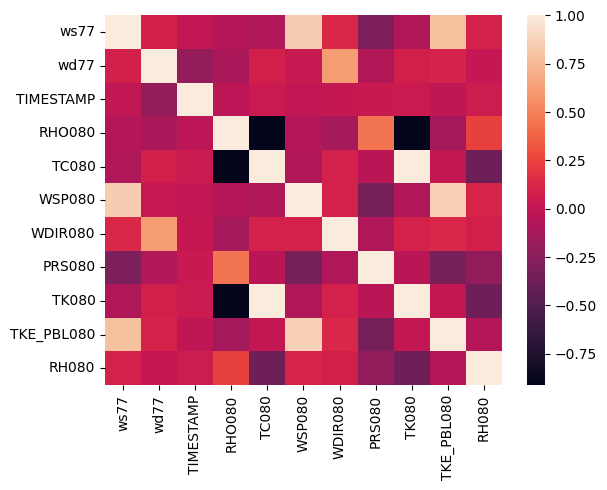

In [10]:
corrM = data.corr()
sns.heatmap(corrM)

In [11]:
corrM

,ws77,wd77,TIMESTAMP,RHO080,TC080,WSP080,WDIR080,PRS080,TK080,TKE_PBL080,RH080
ws77,1.000000,0.084719,-0.004923,-0.054256,-0.080715,0.849325,0.130356,-0.299357,-0.080725,0.788747,0.089609
wd77,0.084719,1.000000,-0.200891,-0.101685,0.075642,0.027780,0.618326,-0.074805,0.075640,0.097328,0.012201
TIMESTAMP,-0.004923,-0.200891,1.000000,-0.023117,0.042447,-0.003272,0.019904,0.035678,0.042449,-0.013240,0.053958
RHO080,-0.054256,-0.101685,-0.023117,1.000000,-0.911155,-0.061123,-0.124329,0.444460,-0.911151,-0.138402,0.240148
TC080,-0.080715,0.075642,0.042447,-0.911155,1.000000,-0.088637,0.094465,-0.036737,1.000000,0.000829,-0.369593
WSP080,0.849325,0.027780,-0.003272,-0.061123,-0.088637,1.000000,0.089860,-0.333350,-0.088646,0.863903,0.107309
WDIR080,0.130356,0.618326,0.019904,-0.124329,0.094465,0.089860,1.000000,-0.085652,0.094459,0.119775,0.075754
PRS080,-0.299357,-0.074805,0.035678,0.444460,-0.036737,-0.333350,-0.085652,1.000000,-0.036727,-0.331179,-0.213414
TK080,-0.080725,0.075640,0.042449,-0.911151,1.000000,-0.088646,0.094459,-0.036727,1.000000,0.000818,-0.369603
TKE_PBL080,0.788747,0.097328,-0.013240,-0.138402,0.000829,0.863903,0.119775,-0.331179,0.000818,1.000000,-0.060076


Column pairs (`WSP080`, `ws77`), (`TK080`, `TC080`), (`TC080`, `RHO080`) and (`TK080`, `RHO080`) are higly correlated (above 0.8).

In [12]:
data = data.drop(columns=['WSP080', 'TK080', 'TC080'])

ws77


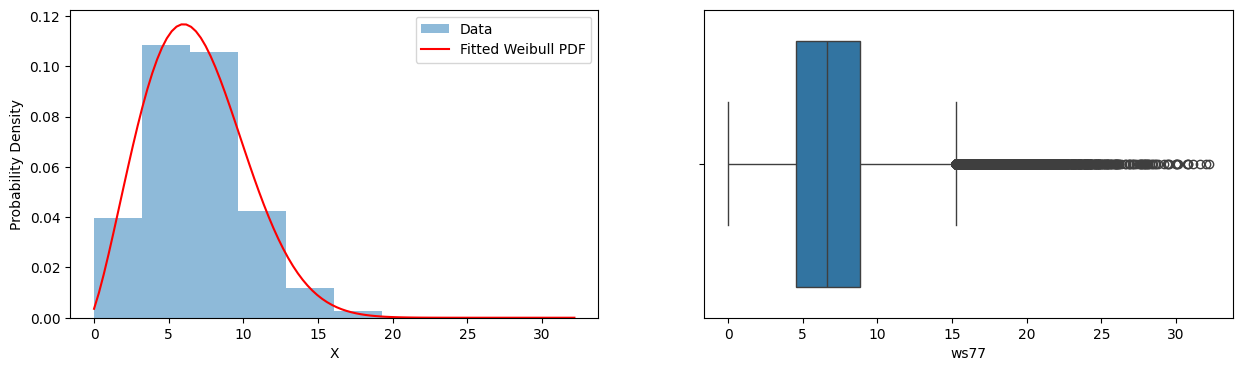

k: shape    2.282285
loc        -0.265257
a: scale    8.062725
dtype: float64
wd77


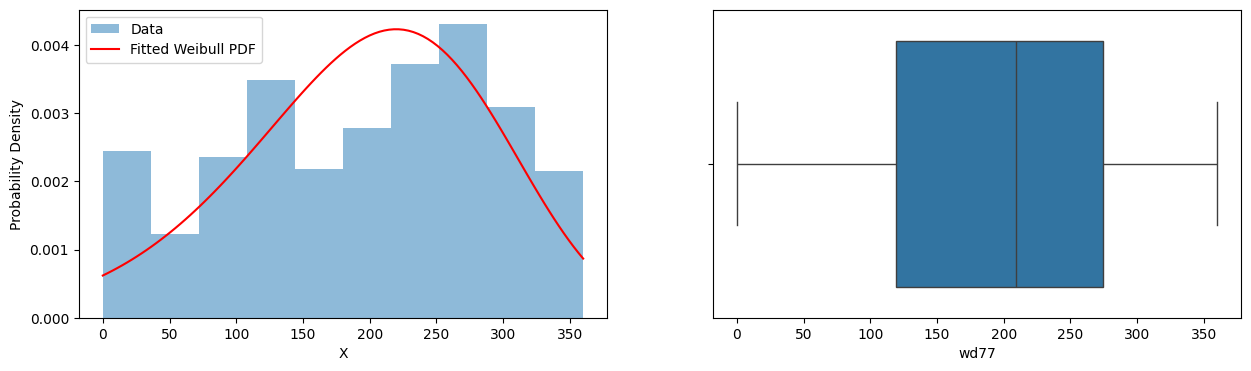

k: shape      6.807964
loc        -364.505394
a: scale    598.154915
dtype: float64


In [13]:
weibull(mast)

ws77


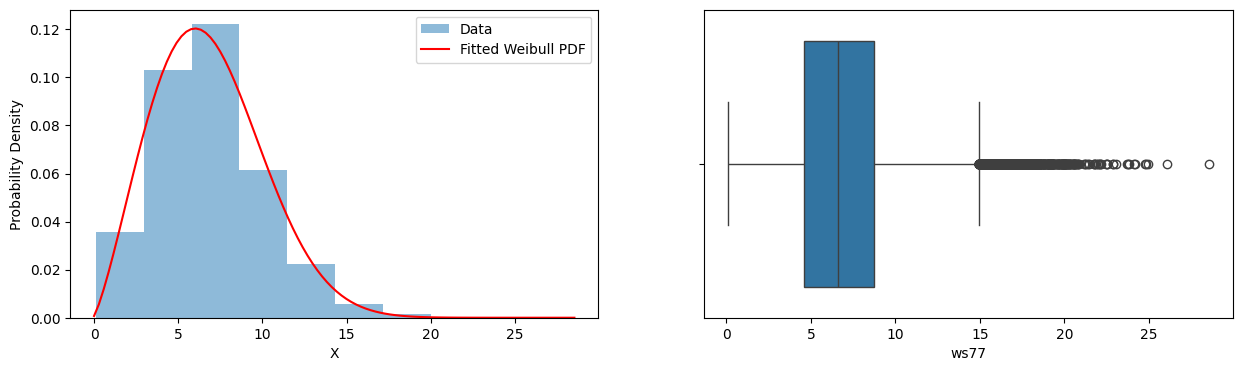

k: shape    2.283441
loc        -0.072324
a: scale    7.821964
dtype: float64
wd77


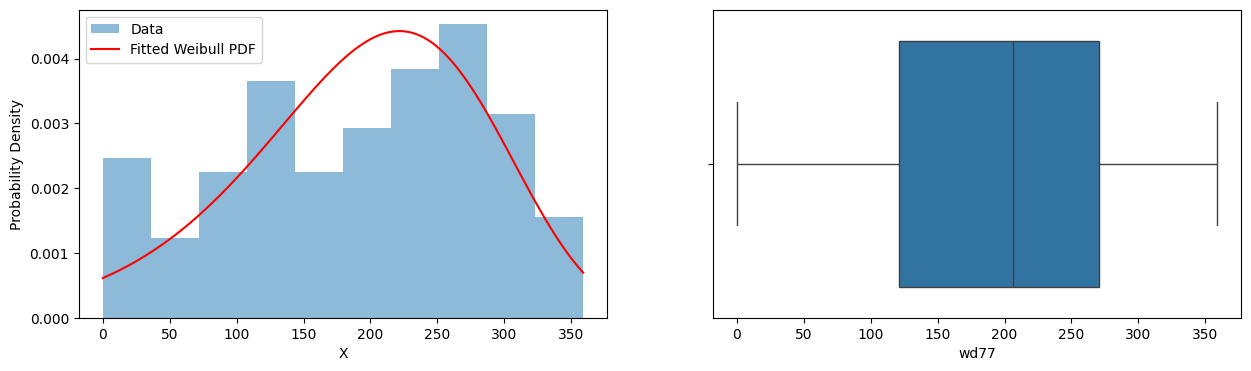

k: shape      9.095921
loc        -529.499798
a: scale    760.837387
dtype: float64


In [14]:
weibull(mast_mean)

ws77


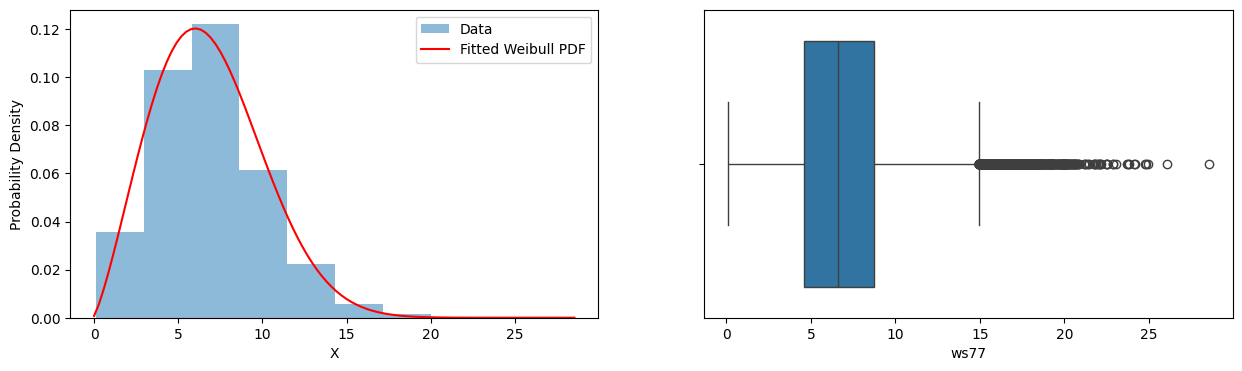

k: shape    2.283020
loc        -0.072424
a: scale    7.822398
dtype: float64
wd77


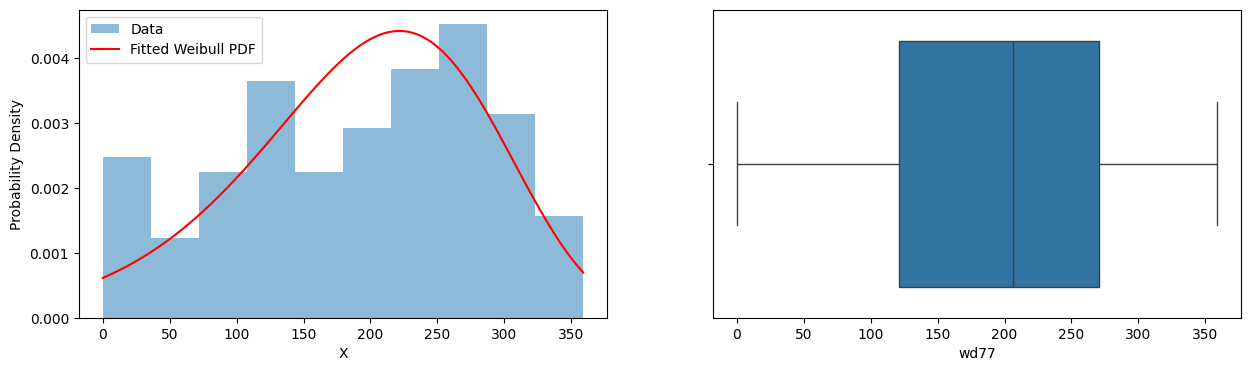

k: shape      9.097098
loc        -530.042436
a: scale    761.370205
dtype: float64
RHO080


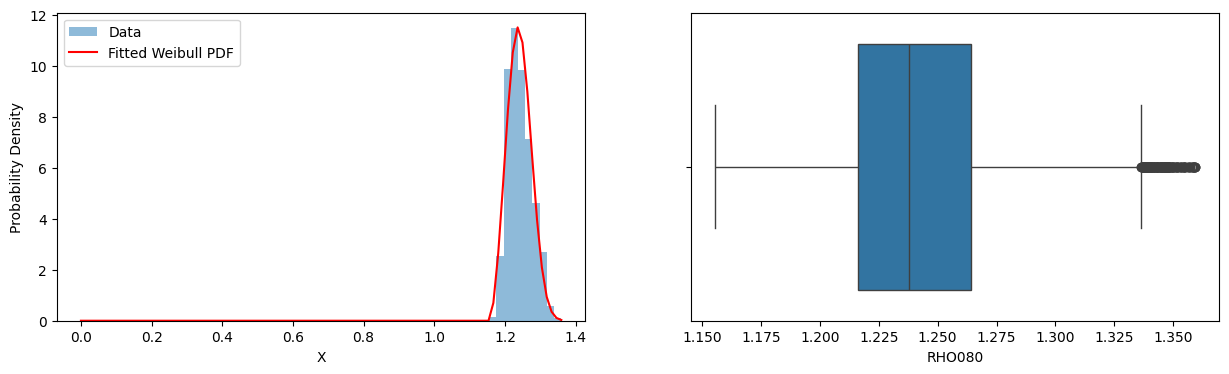

k: shape    2.820292
loc         1.154719
a: scale    0.096744
dtype: float64
WDIR080


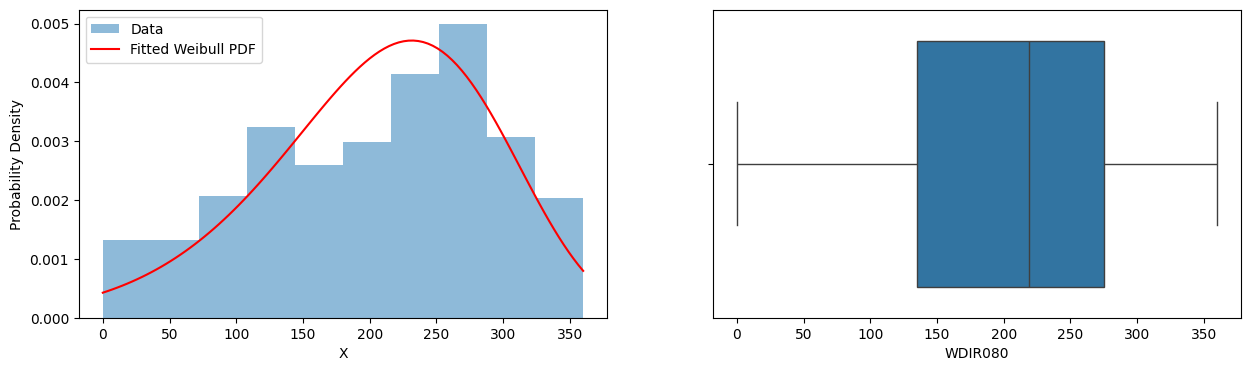

k: shape      8.255955
loc        -407.840606
a: scale    649.442694
dtype: float64
PRS080


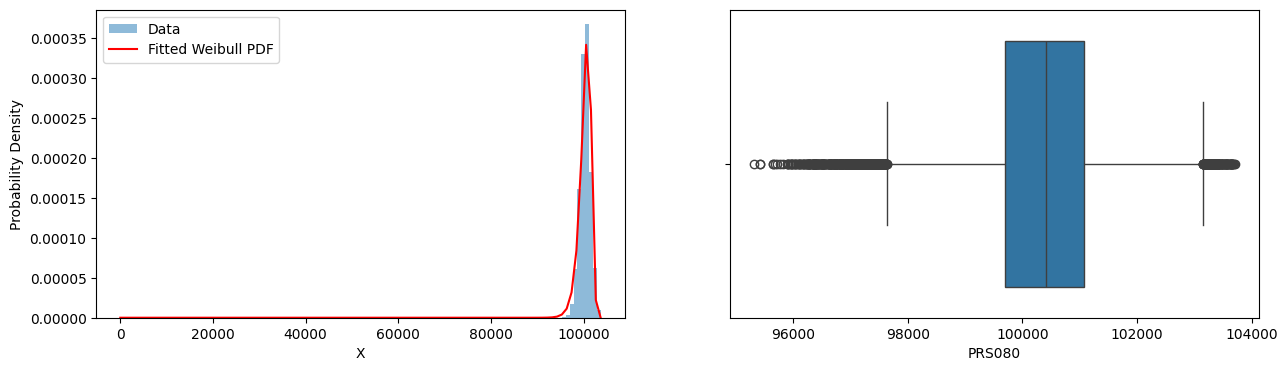

k: shape        97.764782
loc             -0.055925
a: scale    100886.466572
dtype: float64
TKE_PBL080


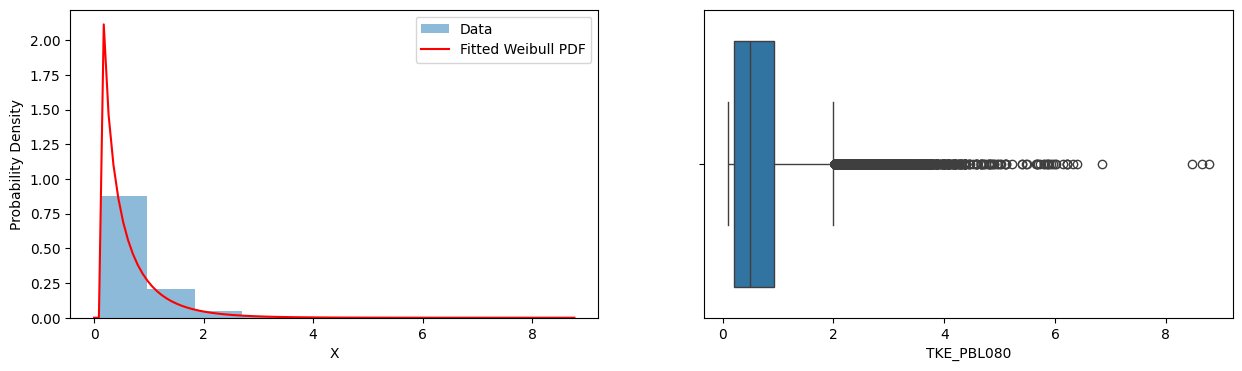

k: shape    0.810517
loc         0.100000
a: scale    0.403654
dtype: float64
RH080


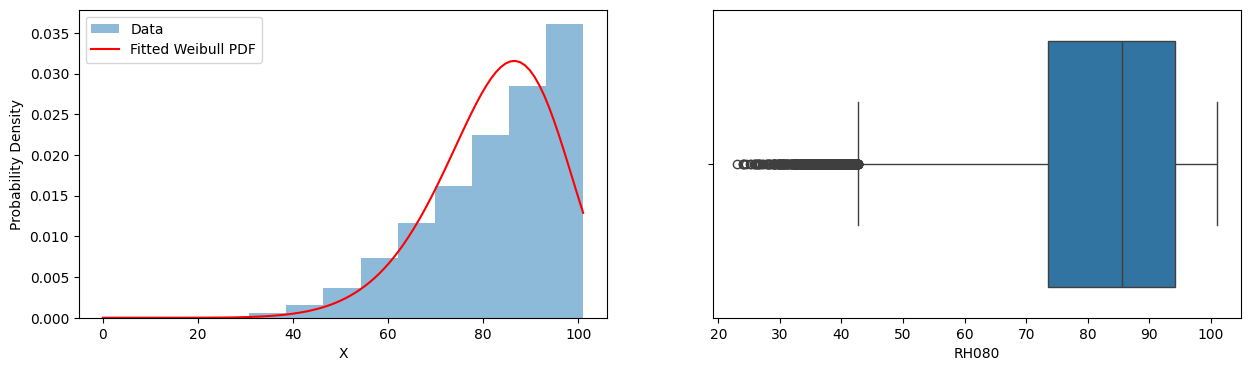

k: shape     7.498035
loc          0.003688
a: scale    88.199178
dtype: float64


In [15]:
weibull(data)

Features ws77 and TKE_PBL080 are right-skewed. However ws77 is the label column and model accuracy decreses when TKE_PBL080 skewness is corrected, which means that skewness is integral to the data.

In [16]:
# split timestamp into columns, ignoring minutes and seconds and adding seasons
data['year'] = data['TIMESTAMP'].apply(lambda d: d.year)
data['month'] = data['TIMESTAMP'].apply(lambda d: d.month)
data['day'] = data['TIMESTAMP'].apply(lambda d: d.day)
data['hour'] = data['TIMESTAMP'].apply(lambda d: d.hour)
data['season'] = data['TIMESTAMP'].apply(lambda d: d.month % 12 // 3)

data = pd.get_dummies(data, prefix='season', columns=['season'], dtype=int)
data = data.drop(columns=['TIMESTAMP'])
data

,ws77,wd77,RHO080,WDIR080,PRS080,TKE_PBL080,RH080,year,month,day,hour,season_0,season_1,season_2,season_3
0,6.42,187.83,1.282629,209.09,100820.96,0.32,98.13,2000,1,1,7,1,0,0,0
1,6.43,202.33,1.281737,204.21,100744.40,0.32,99.90,2000,1,1,8,1,0,0,0
2,6.94,195.17,1.279843,204.75,100697.50,0.42,98.20,2000,1,1,9,1,0,0,0
3,6.89,201.17,1.280179,211.50,100685.36,0.42,98.45,2000,1,1,10,1,0,0,0
4,6.58,199.00,1.279617,217.37,100678.89,0.40,100.62,2000,1,1,11,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67657,5.94,0.00,1.286476,3.15,101321.87,0.32,95.09,2007,12,31,17,1,0,0,0
67658,7.62,0.00,1.293436,11.71,101380.83,0.45,96.83,2007,12,31,18,1,0,0,0
67659,8.73,0.00,1.298469,12.00,101443.59,0.32,98.25,2007,12,31,19,1,0,0,0
67660,8.74,0.00,1.296475,6.64,101474.82,0.32,96.76,2007,12,31,20,1,0,0,0


3. **Model Development:** Use appropriate machine learning principles and methodologies, including model training and testing and perhaps validation, cross-validation, and leave-one-out. You should apply and interpret regression models effectively for this task.